Estimate and plot effects of position

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# Constants
Me=0.51099006
re=2.818E-13
hbarc=1.9732858E-11
e=1.6022E-19
c=2.9979E10
pi=3.141592653589793

# Beam parameters
Ebeam=5000
#Ebeam=11000
Ibeam=1
sigmabeam=300E-4

# Laser parameters
laser_lambda=532E-7
sigmalaser=100E-4
alphac=10E-3
alpha=alphac/2.0
plaser = 5

In [3]:
Elaser = hbarc*2*pi/laser_lambda
gam = Ebeam/Me
a = 1.0/(1 + 4*gam*Elaser/Me)
Egmax = 4*gam**2*a*Elaser
rhomin=Elaser/Egmax

def compton_xsec(rho):
 first = rho**2*(1.0-a)**2/(1.0-rho*(1.-a))
 second = (1-rho*(1+a))/(1-rho*(1-a))
 dsig = 2.*pi*re**2*a*(first+1.0+second**2)
 return dsig
# Start calculating luminosity and cross section
Ne = Ibeam/e/c
Nphot = plaser/(e*1E6*Elaser*c)
Lumisimple = c*(1.0 + np.cos(alphac))*Ne*Nphot/(np.sin(alphac)*np.sqrt(2*pi)*np.sqrt(sigmabeam**2 + sigmalaser**2))
print('Simple luminosity: ', Lumisimple)
xsect = integrate.quad(lambda rho: compton_xsec(rho),rhomin,1.0)
rate = xsect[0]*Lumisimple
print(rate)

Simple luminosity:  7.033923214036582e+30
4001748.5932122236


In [4]:
def dlumi(x,y,z, sigmabeam,sigmalaser,yoff):
    part1=c*(1.0+np.cos(alphac))
    rhobeam = 1.0/(2*pi*sigmabeam**2)*np.exp(-(x*np.cos(alpha)+z*np.sin(alpha))**2/(2*sigmabeam**2))*np.exp(-(y+yoff)**2/(2*sigmabeam**2))
    rholaser = 1.0/(2*pi*sigmalaser**2)*np.exp(-(x*np.cos(alpha)-z*np.sin(alpha))**2/(2*sigmalaser**2))*np.exp(-y**2/(2*sigmalaser**2))
    rhogambeam=part1*rhobeam*rholaser
    return rhogambeam

In [5]:
# Beam-laser offset: 0-200 um
ybeamoff=np.array([0.0,50E-4,100E-4,150E-4, 200E-4])
# size of helicity correlated position difference
# dy=1 um --> huge!
dypos=1E-4
ratenom=np.empty(5); rateplus=np.empty(5); rateminus=np.empty(5); asy=np.empty(5)
i=0
for off in ybeamoff:
    yoff=off
    lumitmp = integrate.tplquad(lambda x, y, z: dlumi(x,y,z,sigmabeam,sigmalaser,yoff), -7.0, 7.0, lambda x: -3.0, lambda x: 3.0, lambda x,y: -3.0, lambda x,y: 3.0)
    Luminosity = Ne*Nphot*lumitmp[0]
    ratenom[i] = xsect[0]*Luminosity
    print(yoff,ratenom[i])
                                
    yoff=off+dypos
    lumitmp = integrate.tplquad(lambda x, y, z: dlumi(x,y,z,sigmabeam,sigmalaser,yoff), -7.0, 7.0, lambda x: -3.0, lambda x: 3.0, lambda x,y: -3.0, lambda x,y: 3.0)
    Luminosity = Ne*(plaser*laser_lambda*2*pi/(hbarc*c))*lumitmp[0]
    rateplus[i] = xsect[0]*Luminosity

    yoff=off-dypos
    lumitmp = integrate.tplquad(lambda x, y, z: dlumi(x,y,z,sigmabeam,sigmalaser,yoff), -7.0, 7.0, lambda x: -3.0, lambda x: 3.0, lambda x,y: -3.0, lambda x,y: 3.0)
    Luminosity = Ne*(plaser*laser_lambda*2*pi/(hbarc*c))*lumitmp[0]
    rateminus[i] = xsect[0]*Luminosity

    asy[i]=(rateplus[i]-rateminus[i])/(rateplus[i]+rateminus[i])

    i=i+1

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.0 3894272.3084283196
0.005 3845896.88088187
0.01 3704346.4067953373
0.015 3479911.403729701
0.02 3188360.499770249


In [6]:
ybeamoff_um = ybeamoff*1E4 # convert to um
asypct = 100*abs(asy) # convert to %
ratekhz=ratenom/1000
dpol = asypct/(100.*0.074)
relrate=ratekhz/ratekhz[0]

Text(0, 0.5, 'Rate (kHz)')

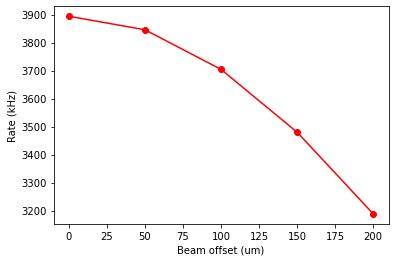

In [7]:
plt.plot(ybeamoff_um,ratekhz,'o-',color='r')
plt.xlabel('Beam offset (um)')
plt.ylabel('Rate (kHz)')

Text(0, 0.5, 'False asymmetry (%)')

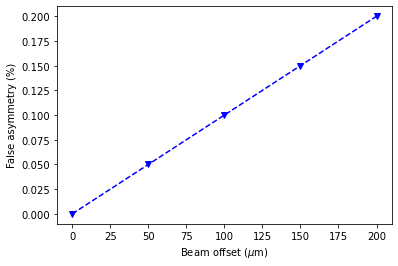

In [8]:
plt.plot(ybeamoff_um,asypct,'v--',color='b')
plt.xlabel('Beam offset ($\mu$m)')
plt.ylabel('False asymmetry (%)')

Text(0, 0.5, '$A_{posdiff}/A_{Compton}$')

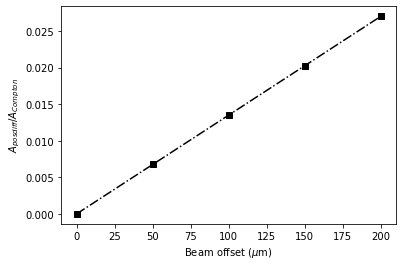

In [9]:
plt.plot(ybeamoff_um,dpol,'s-.', color='black')
plt.xlabel('Beam offset ($\mu$m)')
plt.ylabel('$A_{posdiff}/A_{Compton}$')